# Seminal Work: Classification of objects with deposit using a RaspberryPi
Autoren: Sofie Scharaf, Dominic Viola

## Step 0: Prerequisits

In [1]:
!python --version

Python 3.10.6


In [2]:
# prerequisits
!pip install numpy pandas opencv-python keras tensorflow # if on Apple silicon also use this: tensorflow-metal

In [51]:
# imports and set seed so results are random, but stil reproducable
import tensorflow as tf
import keras
import tensorflow.keras.layers as layers
from sklearn.preprocessing import OneHotEncoder
import random
import os  # Helps you manage files and folders
import cv2  # Working with images
import numpy as np
import seaborn as sns  # Helps you visualize your discoveries
import matplotlib.pyplot as plt  # To plot images

print("tensorflow version: "+ tf.__version__)
print("keras version: ", keras.__version__)

def set_seed(seed=0):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  random.seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = "1"
  os.environ['TF_CUDNN_DETERMINISM'] = "1"
  os.environ['PYTHONHASHSEED'] = str(seed)
  keras.utils.set_random_seed(seed)

set_seed()

tensorflow version: 2.16.1
keras version:  3.3.2


## Step 1: Find Datasets
We want to train a model to recognize and classify different kinds of Cans and bottles.
This will later be used in an IoT system that displays the price one would get for a certain type of can or bottle.

Hence, we need some training data to fine tune an existing model to recognize these classes.
Therefore, we download a dataset that contains can and bottle data, so that we can fine tune a model to recognize and classify them. 
Later on we may need some real world images of the actual cans we want to use our system on.

The CIFAR-100 dataset has come classes in the food_container superclass, that may be interesting for this use-case:
- bottles 
- cans 
- cups

See https://www.cs.toronto.edu/~kriz/cifar.html

Considerations that have to be made: 
1. Train only with the relevant classes and then also train with more classes to see if it improves the model ?
1. Add an additional class for other objects than cans and bottles to prevent many false positives ?


In [4]:
# download the dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode="fine")

In [5]:
label_names = [
    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "crab",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm"
]

In [6]:
# select the classes we want
train_labels = [label_names[int(idx)] for idx in y_train]
test_labels = [label_names[int(idx)] for idx in y_test]
test_labels

/var/folders/f_/mtgsl6n13zd4n7z20x96lx1m0000gn/T/ipykernel_24905/939403219.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_labels = [label_names[int(idx)] for idx in y_train]
/var/folders/f_/mtgsl6n13zd4n7z20x96lx1m0000gn/T/ipykernel_24905/939403219.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_labels = [label_names[int(idx)] for idx in y_test]


['mountain',
 'forest',
 'seal',
 'mushroom',
 'sea',
 'tulip',
 'camel',
 'butterfly',
 'cloud',
 'apple',
 'sea',
 'skunk',
 'streetcar',
 'rocket',
 'lamp',
 'lion',
 'tulip',
 'wolf',
 'rose',
 'orange',
 'rose',
 'mountain',
 'skunk',
 'dinosaur',
 'chimpanzee',
 'can',
 'keyboard',
 'bicycle',
 'bicycle',
 'rose',
 'chair',
 'plate',
 'lawn_mower',
 'turtle',
 'palm_tree',
 'shark',
 'pickup_truck',
 'boy',
 'couch',
 'house',
 'porcupine',
 'cockroach',
 'mountain',
 'shark',
 'palm_tree',
 'clock',
 'lawn_mower',
 'pickup_truck',
 'skunk',
 'castle',
 'beaver',
 'bee',
 'bottle',
 'pear',
 'baby',
 'flatfish',
 'sea',
 'oak_tree',
 'leopard',
 'rocket',
 'snail',
 'crocodile',
 'camel',
 'rabbit',
 'beetle',
 'girl',
 'lion',
 'sunflower',
 'porcupine',
 'tulip',
 'raccoon',
 'train',
 'ray',
 'trout',
 'flatfish',
 'flatfish',
 'sunflower',
 'bowl',
 'snail',
 'clock',
 'sea',
 'snake',
 'orchid',
 'bee',
 'dinosaur',
 'tractor',
 'snake',
 'forest',
 'boy',
 'ray',
 'clock',


<BarContainer object of 100 artists>

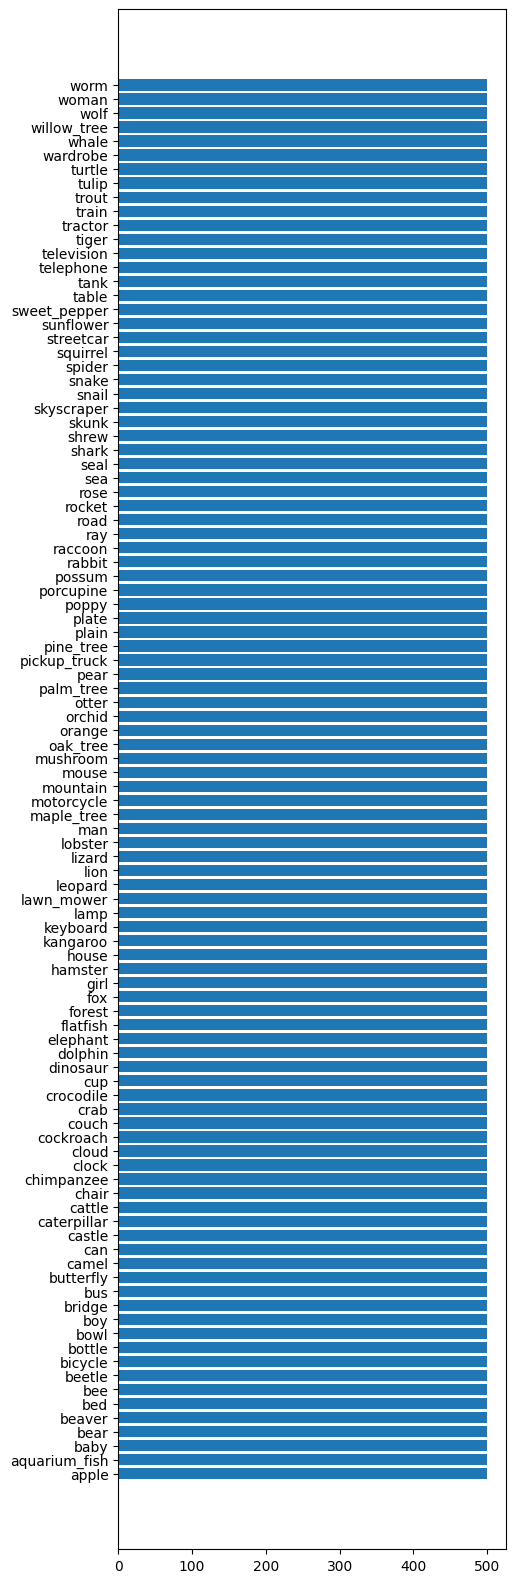

In [7]:
# see how many instances of each class there are
values, counts  = list(np.unique(train_labels, return_counts=True))
class_frequency = list(zip(list(values), list(counts)))

plt.figure(figsize=(5, 20))
plt.barh(y=values, width=counts)

The classes are already balanced, so there is no need to modify the balance within the dataset

In [8]:
def filter_classes(classes: list, x_train: np.array, y_train: np.array, x_test: np.array, y_test: np.array):
    """
    Filter the dataset for the specified class names from the dataset. All other entries will be droped.
    """
    # normalize labels to create a mask
    norm_y_train = y_train.T[0].tolist()
    norm_y_test = y_test.T[0].tolist()

    # the class ids that are used in y_train, y_test
    select_labels = []
    for class_name in classes:
        assert class_name in label_names, f"The class with the name '{class_name}' doesnt exist."
        select_labels.append(label_names.index(class_name))
    
    # select train data points
    train_mask = np.isin(norm_y_train, select_labels)
    
    # select test data points
    test_mask = np.isin(norm_y_test, select_labels)

    return x_train[train_mask], y_train[train_mask], x_test[test_mask], y_test[test_mask]

x_train, y_train, x_test, y_test = filter_classes(["can", "bottle", "cup"], x_train, y_train, x_test, y_test)

In [116]:
def convert_label_ids_to_names(y):
    """
    Converts the ids to the associated label names in the original dataset. Those are not one-hot-labels.

    Input:
    ---
    y: the labels in index form; The index corresponds to the class name as a string in the label_names variable

    Output:
    ---
    output: list of string names of the classes
    """
    output = []
    for l in range(len(y)):
        output.append(label_names[y.T[0][l]])
    return output

#print(y_test)
print(list(zip(y_test, convert_label_ids_to_names(y_test))))

[(array([16]), 'can'), (array([9]), 'bottle'), (array([9]), 'bottle'), (array([16]), 'can'), (array([9]), 'bottle'), (array([28]), 'cup'), (array([28]), 'cup'), (array([16]), 'can'), (array([16]), 'can'), (array([28]), 'cup'), (array([16]), 'can'), (array([28]), 'cup'), (array([9]), 'bottle'), (array([28]), 'cup'), (array([16]), 'can'), (array([16]), 'can'), (array([9]), 'bottle'), (array([28]), 'cup'), (array([9]), 'bottle'), (array([9]), 'bottle'), (array([28]), 'cup'), (array([16]), 'can'), (array([16]), 'can'), (array([9]), 'bottle'), (array([16]), 'can'), (array([28]), 'cup'), (array([9]), 'bottle'), (array([28]), 'cup'), (array([9]), 'bottle'), (array([9]), 'bottle'), (array([16]), 'can'), (array([28]), 'cup'), (array([9]), 'bottle'), (array([16]), 'can'), (array([28]), 'cup'), (array([9]), 'bottle'), (array([9]), 'bottle'), (array([28]), 'cup'), (array([16]), 'can'), (array([28]), 'cup'), (array([28]), 'cup'), (array([28]), 'cup'), (array([16]), 'can'), (array([9]), 'bottle'), (

In [117]:
def labels_to_one_hot(y_train: np.array, y_test:np.array):
    """
    Takes in the class id labels and converts them to one-hot encoded representations.

    output:
    ---
    one_hot_train: One Hot encoded version of the first input 
    one_hot_test: One Hot encoded version of the second input
    categories: A list of the label names; the index in the one hot entry in a vector is equivalent to the index of the corresponding label name in this list
    """
    # preprocess to label names instead of label ids
    y_train_labels = convert_label_ids_to_names(y_train)
    y_test_labels = convert_label_ids_to_names(y_test)

    # to avoid giving the y_train and y_test different one hot locations for the same class, we will combine them into one vector and split them up again afterwards, so the one-hot vectors are consistent between train and test
    y_combined = np.concatenate([y_train_labels, y_test_labels])
    # create a second dimension since OneHotEncoder requires 2D input 
    y_combined = y_combined.reshape(-1, 1)

    encoder = OneHotEncoder(sparse_output=False) #dont use sparse vectors as the output
    y_combined_encoded = encoder.fit_transform(y_combined)
    
    #print(encoder.categories_)

    #split the combined array into train and test labels again
    split_idx = len(y_train)
    one_hot_train, one_hot_test = np.split(y_combined_encoded, [split_idx])
    #print(one_hot_train)

    assert len(one_hot_train) == len(y_train), "Length missmatch between train and one_hot_train"
    assert len(one_hot_test) == len(y_test), "Length missmatch between test and one_hot_test"
    return one_hot_train, one_hot_test, encoder.categories_[0] #categories is shape 1xnum_categories so we need to read 0 to remove the first dim

In [118]:
def one_hot_to_labels(y, categories):
    """
    Input
    ---
    y: The one hot labels of shape num_classes X num_examples
    categories: The categories that the OneHotEncoder returned to convert the one-hot-positions to the corresponding label name

    Output
    ---
    out: The labels y but converted from the one-hot representation to the label names container in categories
    """
    label_idxs = np.argmax(y, axis = 1)
    #print("argmax", label_idxs)
    #print("categories", categories)
    out = []
    for idx in label_idxs:
        out.append(categories[idx])
    return out


In [119]:
one_hot_train, one_hot_test, hot_idx_to_label = labels_to_one_hot(y_train, y_test)

# validate that everything works as intended
orig = convert_label_ids_to_names(y_train)
decoded = one_hot_to_labels(one_hot_train, hot_idx_to_label)
print("Len:", len(orig), len(decoded))
print("original X one-hot\n", list(zip(orig, decoded)))

Len: 1500 1500
original X one-hot
 [('cup', 'cup'), ('bottle', 'bottle'), ('cup', 'cup'), ('cup', 'cup'), ('bottle', 'bottle'), ('cup', 'cup'), ('cup', 'cup'), ('cup', 'cup'), ('bottle', 'bottle'), ('bottle', 'bottle'), ('cup', 'cup'), ('can', 'can'), ('can', 'can'), ('bottle', 'bottle'), ('can', 'can'), ('bottle', 'bottle'), ('can', 'can'), ('cup', 'cup'), ('can', 'can'), ('cup', 'cup'), ('cup', 'cup'), ('bottle', 'bottle'), ('cup', 'cup'), ('bottle', 'bottle'), ('can', 'can'), ('cup', 'cup'), ('can', 'can'), ('bottle', 'bottle'), ('cup', 'cup'), ('bottle', 'bottle'), ('cup', 'cup'), ('can', 'can'), ('cup', 'cup'), ('cup', 'cup'), ('bottle', 'bottle'), ('cup', 'cup'), ('cup', 'cup'), ('can', 'can'), ('bottle', 'bottle'), ('can', 'can'), ('can', 'can'), ('can', 'can'), ('can', 'can'), ('bottle', 'bottle'), ('can', 'can'), ('bottle', 'bottle'), ('can', 'can'), ('cup', 'cup'), ('bottle', 'bottle'), ('cup', 'cup'), ('can', 'can'), ('can', 'can'), ('cup', 'cup'), ('cup', 'cup'), ('bottle',

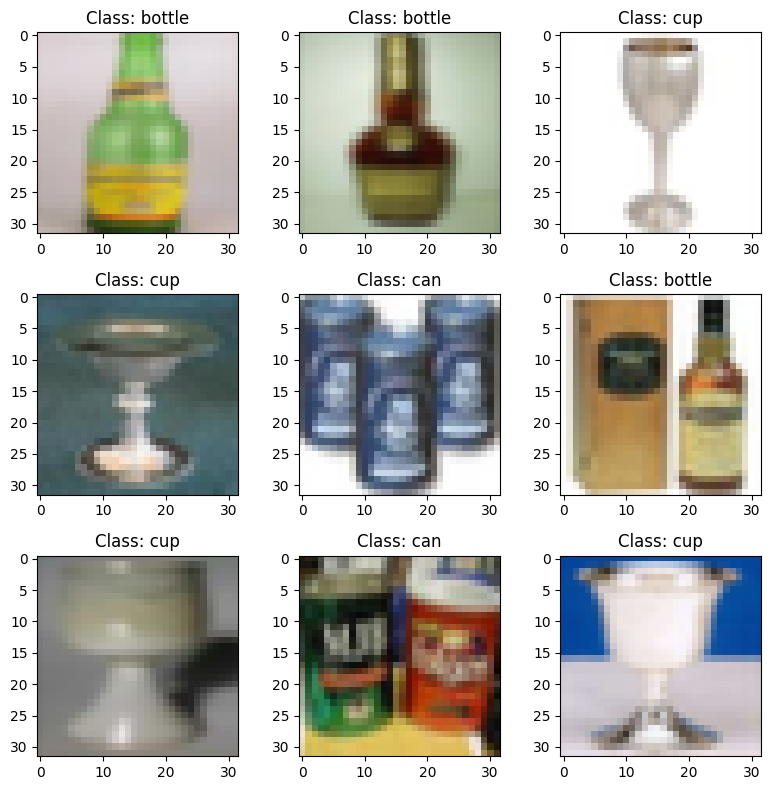

In [10]:
# visualize the remaining data
fig, ax = plt.subplots(3,3)
fig.set_size_inches(8,8)
for i in range(3):
    for j in range (3):
        l = random.randint(0, len(y_test))
        ax[i,j].imshow(x_test[l])
        ax[i,j].set_title('Class: ' + label_names[y_test.T[0][l]])

plt.tight_layout()

## Step 2: Create a Data Augmentation pipeline

In [158]:
augmentation_pipeline = tf.keras.Sequential([
    layers.Input(shape=(32,32,3)),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom((0, -0.25)), #zooms in horizontal and vertical direction and preserves aspect ratio
    layers.RandomBrightness((-0.2, 0.2)), # increase and decrease between 20%
    layers.Lambda(lambda x: tf.cast(x, tf.uint8))
])

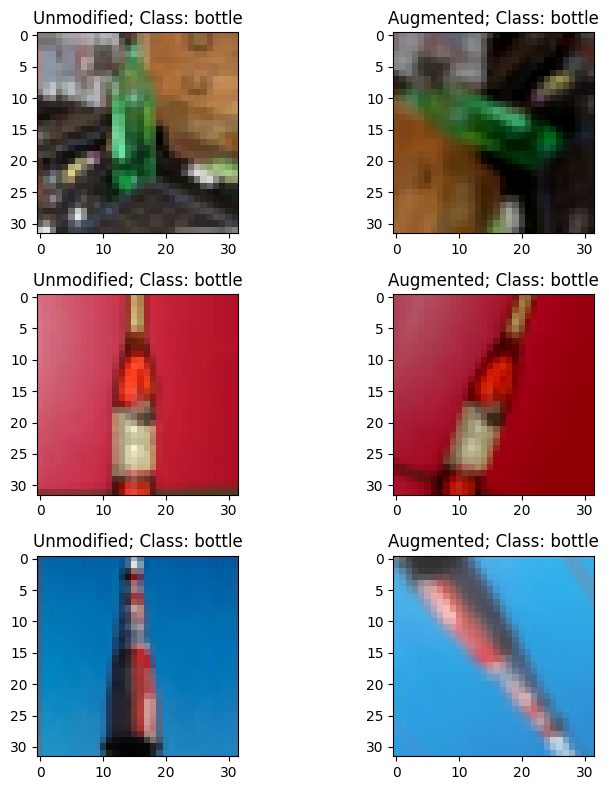

In [165]:
# test the data augmentation pipeline

fig, ax = plt.subplots(3,2)
fig.set_size_inches(8,8)
for i in range(3):
    l = random.randint(0, len(y_test))
    sample = x_test[l]
    #print("Original:", sample)
    ax[i,0].imshow(sample)
    ax[i,0].set_title('Unmodified; Class: ' + label_names[y_test.T[0][l]])

    augmented = augmentation_pipeline(sample[None, :]) # add batch dim (required by the model)
    augmented = np.squeeze(augmented) # remove batch dimenstion (required by matplotlib)
    #print("augmented:", augmented)
    ax[i,1].imshow(augmented)
    ax[i,1].set_title('Augmented; Class: ' + label_names[y_test.T[0][l]])

plt.tight_layout()

## Step 3: Select a backbone
Since the model will be deployed on a RaspberryPi we need a model with few parameters to respect the constraints of the IoT device.

In [173]:
input_shape = (32, 32, 3)

# select the backbone model that will be placed on the Raspberry Pi
mobile_net_backbone = keras.applications.MobileNetV3Large(
    input_shape=input_shape,
    alpha=1.0,
    minimalistic=False,
    include_top=False, #remove the head; only use as backbone
    weights="imagenet",
    input_tensor=None,
    #classes=3, # cup, bottle, can

    pooling=None,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True,
)


/Users/dom/miniconda3/envs/images/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [175]:
# freeze backbone
mobile_net_backbone.trainable = False

# construct the workflow for fine-tuning
input_layer = keras.Input(shape=input_shape, dtype=tf.uint8, name="Input")
x = augmentation_pipeline(input_layer)
x = mobile_net_backbone(x, training=False) #set model to inference and its weights to be non-trainable
# head
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(3, activation="softmax")(x) # cup, bottle, can


# create model with the head
model = keras.Model(input_layer, output)

In [176]:
# to use the CategoricalCrossentropy we need to convert our labels into one hot encoded representation, instead of the indices of the class
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.F1Score()],
)

In [123]:
model.summary()
mobile_net_backbone.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobilenetV3large (Functional)   │ (None, 1, 1, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │         2,883 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,999,235 (11.44 MB)

 Trainable params: 2,883 (11.26 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

Model: "MobilenetV3large"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 32, 32, 3) │          0 │ input_layer_3[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 16, 16,    │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 16, 16,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 16, 16,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        144 │ activation_20[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        256 │ re_lu_19[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 16, 16,    │          0 │ activation_20[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 16, 16,    │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 16, 16,    │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 16, 16,    │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 17, 17,    │          0 │ re_lu_20[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 8, 8, 64)  │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 8, 8, 64)  │        256 │ expanded_conv_1_

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

## Step 4: Fine-Tune and Transfer Learning
Now we use the our cup, bottle and can data to fine tune the new model head that we have attached to our MobileNetV3 backbone. 

In [177]:
# conversion to one-hot representation is needed by CategoricalCrossEntropy
one_hot_train, one_hot_test, hot_idx_to_label = labels_to_one_hot(y_train, y_test)

EPOCHS = 100
# callbacks during training process
early_stop  = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
check_point = tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
history = model.fit(
    x=x_train, y=one_hot_train, epochs=EPOCHS, 
    validation_data=(x_test, one_hot_test), 
    callbacks=[early_stop, check_point]
    )

Epoch 1/100


47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 428ms/step - categorical_accuracy: 0.3606 - f1_score: 0.3580 - loss: 1.4798 - val_categorical_accuracy: 0.4133 - val_f1_score: 0.4134 - val_loss: 1.1873
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - categorical_accuracy: 0.4700 - f1_score: 0.4677 - loss: 1.1300 - val_categorical_accuracy: 0.4633 - val_f1_score: 0.4617 - val_loss: 1.0827
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - categorical_accuracy: 0.5268 - f1_score: 0.5255 - loss: 1.0362 - val_categorical_accuracy: 0.4700 - val_f1_score: 0.4666 - val_loss: 1.0410
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - categorical_accuracy: 0.5713 - f1_score: 0.5693 - loss: 0.9930 - val_categorical_accuracy: 0.4667 - val_f1_score: 0.4582 - val_loss: 0.9976
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - categorical_accuracy: 0.5795 - f1_score: 0.5788 - loss: 0.9533 - val_categorical_accuracy: 0.4967 - val_f1_score: 0.4884 - val_loss: 1.0018
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3

In [178]:
# list the data captured by the history
print(history.history.keys())

dict_keys(['categorical_accuracy', 'f1_score', 'loss', 'val_categorical_accuracy', 'val_f1_score', 'val_loss'])


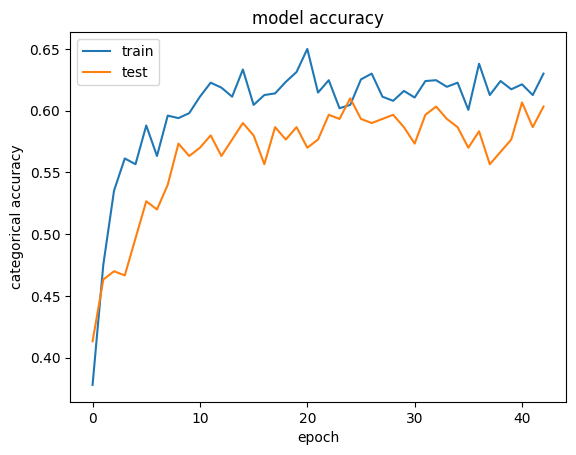

In [179]:

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


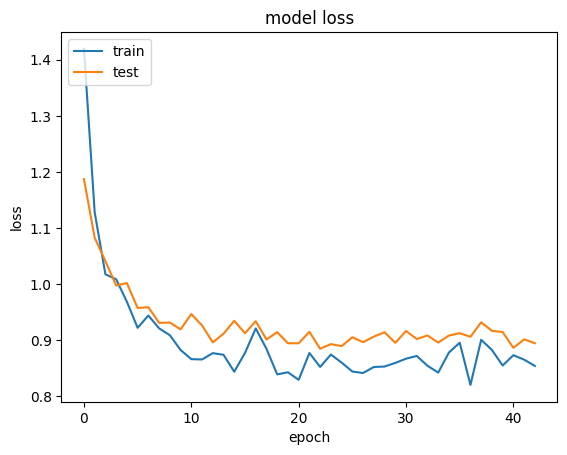

In [180]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Maybe we could train the head for even more epochs?